<a href="https://colab.research.google.com/github/gianinapetrascu/wids-datathon-university-solution1/blob/main/Route1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Title & Team Info

**Project Title**: _Workshop 1: WiDS University Datathon 2026_  
**Team Name**: _Research DUO_  
**University**: _Bucharest University of Economic Studies_  
**Course**: _Software Open Source for Statistics and Data Science_  
**Term**: _1st Semester, 2025_  

**Team Members**:  
- Gianina Petrașcu (GitHub: [@gianinapetrascu](https://github.com/gianinapetrascu))  
- Ioana Bîrlan (GitHub: [@ioanabirlan](https://github.com/ioanabirlan))  


### 🔹 Route 1: Accelerating Equitable Evacuations

**Core Question:**  
*How can we reduce delays in evacuation alerts and improve response times for the communities that are most at risk?*

This route focuses on analyzing how and when evacuation alerts are triggered — and how we can improve timeliness and fairness in communication, especially for vulnerable populations.

## Dataset Overview

Summarize the datasets you used and how you processed them.

- `infrastructure.csv`: Metadata and coordinates of infrastructure
- `fire_perimeters.geojson`: Timestamped fire perimeter polygons
- `evacuation_zones.csv`: (Optional) evacuation declarations
- `watch_duty_change_log.csv`: Alerts and timestamps
- (Optional) NOAA weather data or census data

**Load data**

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gianinamariapetrascu","key":"3b4740567442e05ace027246b5e7d29a"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c wids-university-datathon-2025


 93% 373M/403M [00:00<00:00, 406MB/s]
100% 403M/403M [00:01<00:00, 405MB/s]


In [5]:
!unzip wids-university-datathon-2025.zip -d data/

Archive:  wids-university-datathon-2025.zip
  inflating: data/WiDS _-_ Watch Duty_ Data Dictionary.docx  
  inflating: data/evac_zone_status_geo_event_map.csv  
  inflating: data/evac_zones_gis_evaczone.csv  
  inflating: data/evac_zones_gis_evaczonechangelog.csv  
  inflating: data/fire_perimeters_gis_fireperimeter.csv  
  inflating: data/fire_perimeters_gis_fireperimeterchangelog.csv  
  inflating: data/geo_events_externalgeoevent.csv  
  inflating: data/geo_events_externalgeoeventchangelog.csv  
  inflating: data/geo_events_geoevent.csv  
  inflating: data/geo_events_geoeventchangelog.csv  


In [6]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme()
plt.colormaps()

from sklearn.model_selection import train_test_split


In [7]:
events    = pd.read_csv("data/geo_events_geoevent.csv", low_memory=True)
changes   = pd.read_csv("data/geo_events_geoeventchangelog.csv", low_memory=True)
perims    = pd.read_csv("data/fire_perimeters_gis_fireperimeter.csv", low_memory=True)
evac      = pd.read_csv("data/evac_zones_gis_evaczone.csv", low_memory=True)
evac_map  = pd.read_csv("data/evac_zone_status_geo_event_map.csv", low_memory=True)

In [8]:
print("Loaded:")
for name, df in zip(["events","changes","perims","evac","evac_map"],
                    [events,changes,perims,evac,evac_map]):
    print(f"  {name:10s} {df.shape}")

Loaded:
  events     (62696, 17)
  changes    (178697, 5)
  perims     (6207, 14)
  evac       (37458, 16)
  evac_map   (4429, 3)


In [9]:
events.head()

id                date_created               date_modified geo_event_type  \
0  76  2021-08-11 00:09:56.481066  2023-02-09 20:34:24.180117       wildfire   
1  77  2021-08-11 07:21:46.054995  2023-02-09 20:34:24.225186       wildfire   
2  78  2021-08-11 21:02:16.301416  2023-02-09 20:34:24.266124       wildfire   
3  79  2021-08-12 01:46:31.043052  2023-02-09 20:34:24.308048       wildfire   
4  80  2021-08-12 02:40:30.939331  2023-02-09 20:34:24.358582       wildfire   

              name  is_active  description  \
0        Todd Fire          0          NaN   
1  Vegetation Fire          0          NaN   
2        Ford Fire          0          NaN   
3  Vegetation Fire          0          NaN   
4   Shoreline Fire          0          NaN   

                                             address        lat         lng  \
0  Llano Rd & Todd Rd, Santa Rosa,  California 95...  38.386100 -122.769299   
1  Guerneville Rd & W Steele Ln, Santa Rosa, CA 9...  38.459967 -122.728927   
2  CA-1 & Valley Ford Estero Rd, Valley Ford, CA ...  38.318328 -122.925698   
3         19428 Redwood Dr, Monte Rio, CA 95462, USA  38.479988 -122.994156   
4                  Shoreline Dr, Napa, CA 94558, USA  38.315222 -122.276532   

                                                data notification_type  \
0  {"is_fps": false, "acreage": 50, "containment"...            normal   
1  {"is_fps": false, "acreage": 0, "containment":...            normal   
2  {"is_fps": false, "acreage": 0, "containment":...            normal   
3  {"is_fps": false, "acreage": 0, "containment":...            normal   
4  {"is_fps": false, "acreage": 0, "containment":...            normal   

  external_id external_source  incident_id  reporter_managed  is_visible  
0  1008375748      pulsepoint         76.0                 1           0  
1  1008583077      pulsepoint         77.0                 1           0  
2  1008957703      pulsepoint         78.0                 1           0  
3  1009152928      pulsepoint         79.0                 1           0  
4  1009187142      pulsepoint         80.0                 1           0

In [10]:
changes.head()

id                date_created  \
0  1.0  2024-06-19 00:30:52.819841   
1  2.0  2024-06-19 00:31:10.439467   
2  3.0  2024-06-19 00:31:25.085624   
3  4.0  2024-06-19 00:31:45.603726   
4  5.0  2024-06-19 00:31:51.368137   

                                             changes  geo_event_id  \
0    {"name": ["Vegetation Fire", "Charlotte Fire"]}       22339.0   
1  {"data.links": [[], [{"label": "Pulsepoint Inc...       22338.0   
2  {"address": ["W Ave C & 110th St W, Antelope A...       22339.0   
3                                                 {}       22339.0   
4                        {"data.acreage": [null, 3]}       22339.0   

   user_created_id  
0             16.0  
1          46044.0  
2             16.0  
3             16.0  
4             16.0

In [11]:
perims.head()

id                   date_created                  date_modified  \
0   1  2025-01-21 01:23:38.648183+00  2025-01-21 01:23:38.648194+00   
1   2  2025-01-21 11:26:32.839327+00  2025-02-07 19:20:06.614662+00   
2   3  2025-01-21 13:56:01.312899+00  2025-01-21 17:29:49.778747+00   
3   4  2025-01-21 17:28:32.932429+00  2025-02-07 19:21:08.392032+00   
4   5  2025-01-22 03:00:30.938039+00  2025-02-07 19:21:34.386528+00   

   geo_event_id approval_status          source  \
0       40388.0         pending            nifc   
1       40930.0        approved           firis   
2       40932.0        approved           firis   
3       40932.0        approved  cal_fire_intel   
4       41005.0        approved  cal_fire_intel   

                       source_unique_id         source_date_current  \
0  2a0b8caf-d5bb-48e1-94d7-2590f66b0355      2025-01-18 23:33:05+00   
1  53bb0a67-7739-4be6-af9f-d63bc9c82b9d  2025-01-21 11:20:26.694+00   
2  4f4e79d2-f6d0-4bf7-a945-ea3aacb99dc6  2025-01-21 11:49:47.798+00   
3  f651649a-9fbf-4b4b-bf4f-77022995bb8f      2025-01-21 16:37:00+00   
4  a7b6c718-f7f8-4803-abf2-043bfbce2caf      2025-01-22 02:33:00+00   

  source_incident_name  source_acres  \
0                Eaton  14021.108712   
1     CA-SDU-PALA-N40Y     16.842322   
2    CA-SDU-LILAC-N40Y     80.054733   
3                LILAC     80.760000   
4                 CLAY     38.010000   

                                                geom  is_visible  \
0  SRID=4326;MULTIPOLYGON(((-118.083071 34.237698...       False   
1  SRID=4326;POLYGON((-117.1615690000001 33.36066...        True   
2  SRID=4326;MULTIPOLYGON(((-117.157505 33.307591...       False   
3  SRID=4326;MULTIPOLYGON(((-117.174482 33.301411...        True   
4  SRID=4326;MULTIPOLYGON(((-117.4792139999999 33...        True   

   is_historical source_extra_data  
0          False               NaN  
1           True               NaN  
2          False               NaN  
3           True               NaN  
4           True               NaN

In [12]:
evac.head()

id                   date_created                  date_modified  \
0   1  2025-04-10 13:22:22.896704+00  2025-08-19 01:58:01.009206+00   
1   2  2025-04-10 13:22:22.896921+00   2025-08-19 01:58:01.00957+00   
2   3  2025-04-10 13:22:22.897002+00  2025-08-19 01:58:01.009741+00   
3   4  2025-04-10 13:22:22.897075+00  2025-08-19 01:58:01.009867+00   
4   5  2025-04-10 13:22:22.897156+00  2025-08-19 01:58:01.010002+00   

                                  uid_v2  is_active display_name  region_id  \
0  boulder-CO_US-BO-030-cc87104888faec63       True       BO-030        664   
1  boulder-CO_US-BO-023-bf0c7318a31e33c2       True       BO-023        664   
2  boulder-CO_US-BO-031-d365d7b1d6a30d16       True       BO-031        664   
3  boulder-CO_US-BO-005-ccd5de89e7c9e57a       True       BO-005        664   
4  boulder-CO_US-BO-028-2693ee3d2f362647       True       BO-028        664   

  source_attribution   dataset_name source_extra_data  \
0    Genasys Protect  boulder-CO_US                {}   
1    Genasys Protect  boulder-CO_US                {}   
2    Genasys Protect  boulder-CO_US                {}   
3    Genasys Protect  boulder-CO_US                {}   
4    Genasys Protect  boulder-CO_US                {}   

                                                geom status  \
0  SRID=4326;POLYGON((-105.281982421875 40.000070...    NaN   
1  SRID=4326;POLYGON((-105.2254199981689 40.01466...    NaN   
2  SRID=4326;POLYGON((-105.2583789825439 40.01459...    NaN   
3  SRID=4326;POLYGON((-105.260009765625 40.051007...    NaN   
4  SRID=4326;POLYGON((-105.2680778503418 40.00368...    NaN   

                                          geom_label  is_pending_review  \
0  SRID=4326;POINT(-105.2735804268792 40.00182377...              False   
1  SRID=4326;POINT(-105.2345969160621 40.02228713...              False   
2  SRID=4326;POINT(-105.2665242186653 40.00886663...              False   
3  SRID=4326;POINT(-105.2727102634684 40.04935539...              False   
4  SRID=4326;POINT(-105.2773198758852 40.00651191...              False   

   pending_updates external_status  
0              NaN          Normal  
1              NaN          Normal  
2              NaN          Normal  
3              NaN          Normal  
4              NaN          Normal

In [13]:
evac_map.head()

date_created                                    uid_v2  \
0  2023-10-25 11:28:15.254517    sierra-CA_US-SIE-E062-778dddb3cad71e9f   
1  2023-10-25 11:28:15.254550    sierra-CA_US-SIE-E063-f59f54f1edf93b15   
2  2023-10-25 11:28:15.254565    sierra-CA_US-SIE-E060-64dbd0e15d47d9bb   
3  2023-11-02 21:52:49.867450  butte-CA_US-BUT-CNE-311-474a247dbeb74ebf   
4  2024-05-02 20:53:00.964490       kern-CA_US-KRN-289-7cd3f4bbc76a4b2d   

   geo_event_id  
0         14107  
1         14107  
2         14107  
3         14505  
4         18785

In [14]:
import pandas as pd
import numpy as np
import json

events = events[[
    "id", "date_created", "date_modified", "geo_event_type",
    "name", "is_active", "lat", "lng", "data"]].copy()

def extract_json_field(js, key):
    if not isinstance(js, str) or "{" not in js:
        return None
    try:
        js = js.strip().strip('"').strip("'")
        parsed = json.loads(js)
        return parsed.get(key)
    except Exception:
        return None

for col in [
    "is_prescribed", "is_fps", "containment", "acreage",
    "evacuation_notes", "evacuation_orders", "evacuation_warnings"]:
    events[col] = events["data"].apply(lambda x: extract_json_field(x, col))

events.drop(columns=["data"], inplace=True, errors="ignore")

changes = changes[[c for c in ["geo_event_id","date_created","changes"] if c in changes.columns]].copy()

perims = perims[[c for c in [
    "geo_event_id","approval_status","date_created",
    "source_date_current","geom","source_acres"] if c in perims.columns]].copy()
if "approval_status" in perims.columns:
    perims = perims.query("approval_status == 'approved'").copy()

evac = evac[[c for c in [
    "uid_v2","display_name","region_id","is_active",
    "status","source_attribution","geom","geom_label"] if c in evac.columns]].copy()

assert {"geo_event_id","uid_v2"}.issubset(evac_map.columns), "Mapping table must include geo_event_id and uid_v2"

print("\nAfter cleaning:")
print(f"  events   {events.shape}")
print(f"  changes  {changes.shape}")
print(f"  perims   {perims.shape} (approved only)")
print(f"  evac     {evac.shape}")

print("\nExtracted fields preview:")
print(events[["id","geo_event_type","containment","acreage","is_fps","is_prescribed"]].head(10))

print("\nNon-null counts for extracted fields:")
print(events[["containment","acreage","is_fps","is_prescribed"]].notna().sum())



After cleaning:
  events   (62696, 15)
  changes  (178697, 3)
  perims   (4139, 6) (approved only)
  evac     (37458, 8)

Extracted fields preview:
   id geo_event_type  containment  acreage is_fps is_prescribed
0  76       wildfire        100.0     50.0  False         False
1  77       wildfire        100.0      0.0  False         False
2  78       wildfire          0.0      0.0  False         False
3  79       wildfire          0.0      0.0  False         False
4  80       wildfire        100.0      0.0  False         False
5  81       wildfire        100.0      0.0  False         False
6  82       wildfire          NaN      NaN  False         False
7  83       wildfire        100.0      1.0  False         False
8  84       wildfire          0.0      0.0  False         False
9  85       wildfire        100.0      0.0  False         False

Non-null counts for extracted fields:
containment      24977
acreage          50460
is_fps           26792
is_prescribed    61779
dtype: int64


In [15]:
# timestamps sparsing

def to_dt(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    return df

events  = to_dt(events,  ["date_created","date_modified"])
changes = to_dt(changes, ["date_created"])
perims  = to_dt(perims,  ["date_created","source_date_current"])

In [16]:
# merging datasets

merged = changes.merge(events, left_on="geo_event_id", right_on="id", how="left", suffixes=("_chg","_evt"))
merged = merged.merge(perims, on="geo_event_id", how="left", suffixes=("","_perim"))
merged = merged.merge(evac_map[["geo_event_id","uid_v2"]].drop_duplicates(),on="geo_event_id", how="left")
merged = merged.merge(evac.drop_duplicates("uid_v2"),on="uid_v2", how="left", suffixes=("","_evac"))

print("Merged dataset:", merged.shape)

Merged dataset: (3398402, 31)


In [17]:
merged.tail(10)

geo_event_id                 date_created_chg  \
3398392       60409.0 2025-09-05 15:52:07.011238+00:00   
3398393       60409.0 2025-09-05 15:52:07.011238+00:00   
3398394       60409.0 2025-09-05 15:52:07.011238+00:00   
3398395       60409.0 2025-09-05 15:52:07.011238+00:00   
3398396       60409.0 2025-09-05 15:52:07.011238+00:00   
3398397       60409.0 2025-09-05 15:52:07.011238+00:00   
3398398       60409.0 2025-09-05 15:52:07.011238+00:00   
3398399       60409.0 2025-09-05 15:52:07.011238+00:00   
3398400       60409.0 2025-09-05 15:52:07.011238+00:00   
3398401       60409.0 2025-09-05 15:52:07.011238+00:00   

                                                   changes       id  \
3398392  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398393  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398394  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398395  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398396  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398397  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398398  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398399  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398400  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   
3398401  {"radio_traffic_indicates_rate_of_spread": [nu...  60409.0   

                        date_created_evt                    date_modified  \
3398392 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398393 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398394 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398395 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398396 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398397 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398398 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398399 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398400 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   
3398401 2025-08-17 19:43:12.031143+00:00 2025-09-05 18:28:16.659652+00:00   

        geo_event_type        name  is_active        lat  ...  \
3398392       wildfire  Derby Fire        1.0  39.849463  ...   
3398393       wildfire  Derby Fire        1.0  39.849463  ...   
3398394       wildfire  Derby Fire        1.0  39.849463  ...   
3398395       wildfire  Derby Fire        1.0  39.849463  ...   
3398396       wildfire  Derby Fire        1.0  39.849463  ...   
3398397       wildfire  Derby Fire        1.0  39.849463  ...   
3398398       wildfire  Derby Fire        1.0  39.849463  ...   
3398399       wildfire  Derby Fire        1.0  39.849463  ...   
3398400       wildfire  Derby Fire        1.0  39.849463  ...   
3398401       wildfire  Derby Fire        1.0  39.849463  ...   

                                                      geom source_acres  \
3398392  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398393  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398394  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398395  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398396  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398397  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398398  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398399  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398400  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   
3398401  SRID=4326;MULTIPOLYGON(((-107.099254 39.847388...  5452.612969   

                                          uid_v2  display_name  region_id  \
3398392     eagle-CO_US-GYF-300-48fed2c7030e707c       GYF-300      682.0   
3398393     eagle-CO_US-GYF-327-e045e82a9636

In [18]:

# Missing values
missing_values = pd.DataFrame({
    'Variable': merged.columns,
    'Missing values count': merged.isnull().sum().values,
    'Missing values %': (merged.isnull().sum().values / len(merged) * 100)})

# Unique values
unique_values = pd.DataFrame({
    'Variable': merged.columns,
    'Unique values count': merged.nunique().values})

# Data types
feature_types = pd.DataFrame({
    'Variable': merged.columns,
    'Data type': merged.dtypes.astype(str)})

# Merge all summaries
summary_df = (missing_values
    .merge(unique_values, on='Variable', how='left')
    .merge(feature_types, on='Variable', how='left'))

# Sort by missing percentage
summary_df = summary_df.sort_values(by='Missing values %', ascending=False)

# Style and display with Matplotlib colormap
summary_df.style.background_gradient(cmap='rocket_r').format({
    'Missing values %': '{:.2f}',
    'Unique values count': '{:,}',
    'Missing values count': '{:,}'})


## Approach

In [19]:
# alert lag ( date_modified (in events)- date_created_chg (in changelog))

ref_col = "date_modified" if "date_modified" in merged.columns else "date_created_evt"
if ref_col not in merged.columns and "date_created" in merged.columns:
    merged.rename(columns={"date_created":"date_created_evt"}, inplace=True)
    ref_col = "date_created_evt"

merged["lag_min"] = (merged[ref_col] - merged["date_created_chg"]).dt.total_seconds() / 60
merged["lag_min"] = merged["lag_min"].replace([np.inf, -np.inf], np.nan)
merged["delayed"] = (merged["lag_min"] > 1440).astype(int) #1440 mins = 24h

print("Delayed rate:", round(merged["delayed"].mean(), 4))

Delayed rate: 0.9461


Descriptive statistics for lag:
count    3.398386e+06
mean     2.868629e+04
std      2.028749e+04
min     -1.499979e+03
10%      5.585476e+03
25%      1.571667e+04
50%      2.564913e+04
75%      3.766384e+04
90%      5.403125e+04
max      7.869872e+05
Name: lag_min, dtype: float64


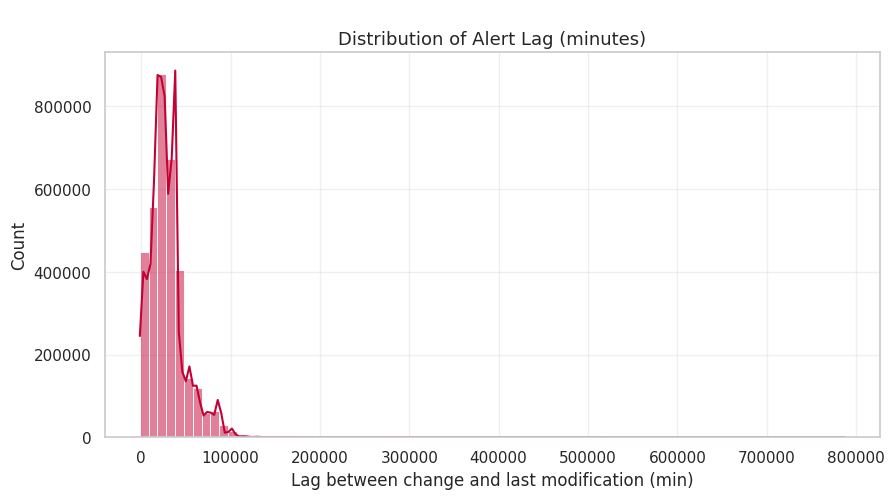

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import numpy as np

main_color = "#c20235"
sns.set_theme(style="whitegrid")

print("Descriptive statistics for lag:")
print(merged['lag_min'].describe(percentiles=[.1, .25, .5, .75, .9]))

# Overall lag distribution
plt.figure(figsize=(10,5))
sns.histplot(merged['lag_min'], bins=80, kde=True, color=main_color)
plt.title("\nDistribution of Alert Lag (minutes)", fontsize=13)
plt.xlabel("Lag between change and last modification (min)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


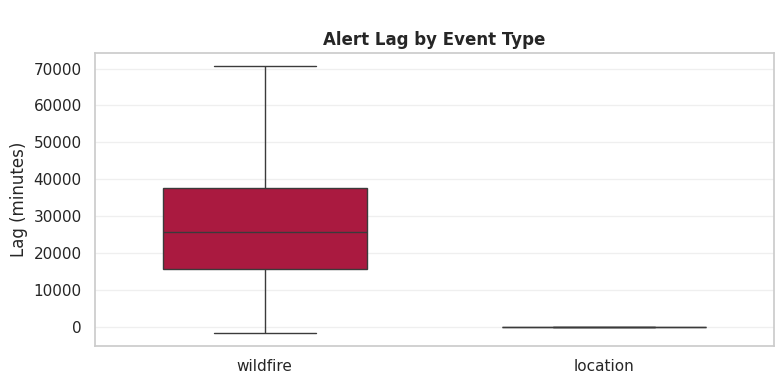

In [21]:
# Lag by event type
plt.figure(figsize=(8,4))
sns.boxplot(
    data=merged,
    x='geo_event_type',
    y='lag_min',
    showfliers=False,
    color=main_color,
    width=0.6
)

plt.title("\nAlert Lag by Event Type", fontsize=12, fontweight="bold")
plt.ylabel("Lag (minutes)")
plt.xlabel("")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

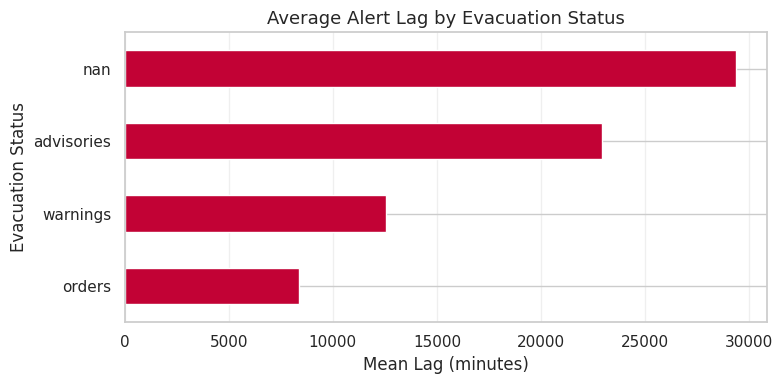

status
orders         8362.043334
warnings      12557.010270
advisories    22944.914765
NaN           29375.489367
Name: lag_min, dtype: float64


In [22]:
import matplotlib.pyplot as plt

if "status" in merged.columns:
    avg_lag_by_status = (
        merged.groupby("status", dropna=False)["lag_min"]
        .mean()
        .sort_values()
    )

    plt.figure(figsize=(8,4))
    avg_lag_by_status.plot(
        kind="barh",
        color= main_color
    )
    plt.title("Average Alert Lag by Evacuation Status", fontsize=13)
    plt.xlabel("Mean Lag (minutes)")
    plt.ylabel("Evacuation Status")
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(avg_lag_by_status)



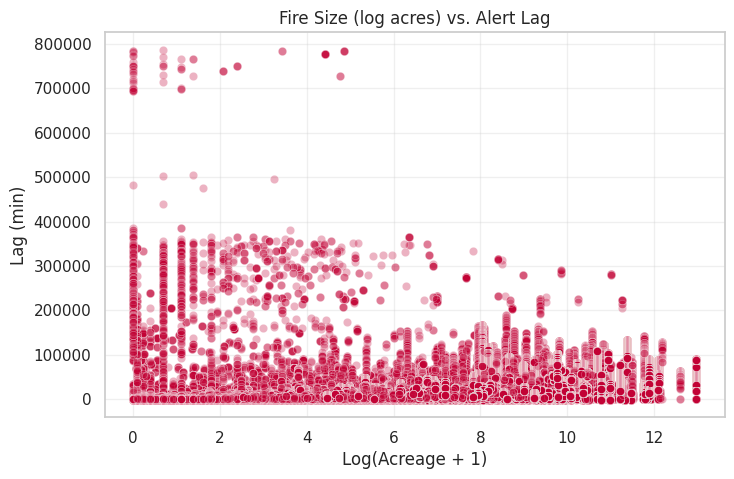

In [23]:
# Delay rate by fire size
if "acreage" in merged.columns:
    merged['log_acreage'] = np.log1p(pd.to_numeric(merged['acreage'], errors='coerce'))
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        data=merged,
        x='log_acreage',
        y='lag_min',
        alpha=0.3,
        color=main_color
    )
    plt.title("Fire Size (log acres) vs. Alert Lag")
    plt.xlabel("Log(Acreage + 1)")
    plt.ylabel("Lag (min)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [24]:
import folium
import numpy as np

if {"lat","lng","lag_min"}.issubset(merged.columns):
    # Sample at most 2000 points for speed
    geo_delay = merged.dropna(subset=['lat','lng','lag_min']).sample(n=min(2000, len(merged)), random_state=42)
    geo_delay['Lag (min)'] = geo_delay['lag_min'].round(1)
    geo_delay['Popup'] = (
        "<b>" + geo_delay['name'].astype(str) + "</b><br>"
        "Lag: " + geo_delay['Lag (min)'].astype(str) + " min<br>"
        "Containment: " + geo_delay['containment'].astype(str) + "%<br>"
        "Acreage: " + geo_delay['acreage'].astype(str)
    )

    m = folium.Map(
        location=[geo_delay['lat'].mean(), geo_delay['lng'].mean()],
        zoom_start=6,
        tiles="CartoDB positron"
    )

    # markers
    for _, row in geo_delay.iterrows():
        color = (
            "#67a56f" if row["lag_min"] < 1440 else  # <1 day
            "#E26A4A" if row["lag_min"] < 10080 else  # <1 week
            "#4B0082"  # >1 week
        )
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(row['Popup'], max_width=300)
        ).add_to(m)

    # legend
    legend_html = """
     <div style="
         position: fixed;
         bottom: 50px; left: 50px; width: 180px; height: 120px;
         background-color: white;
         border:2px solid grey; z-index:9999; font-size:14px;
         box-shadow: 2px 2px 4px rgba(0,0,0,0.3);
         ">
         &nbsp;<b>Alert Lag Legend</b><br>
         &nbsp;<i style="background:#67a56f;color:#67a56f;">.....</i>&nbsp; < 1 day<br>
         &nbsp;<i style="background:#E26A4A;color:#E26A4A;">.....</i>&nbsp; 1–7 days<br>
         &nbsp;<i style="background:#4B0082;color:#4B0082;">.....</i>&nbsp; > 7 days<br>
     </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    m.save("delay_map_sampled_with_legend.html")
    display(m)


  ML models

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import shap
import joblib

sns.set_theme(style="whitegrid")


In [26]:
# data preparation
features = ["containment", "acreage", "is_fps", "is_prescribed", "lat", "lng"]
merged["delayed"] = (merged["lag_min"] > 60).astype(int)

for f in features:
    merged[f] = pd.to_numeric(merged[f], errors="coerce")

model_data = merged.dropna(subset=features + ["delayed"]).copy()
X = model_data[features]
y = model_data["delayed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2616921, 6), Test shape: (654231, 6)


In [28]:
# # random forest
# rf_params = {
#     "n_estimators": [200, 400],
#     "max_depth": [10, 20, None],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2],
#     "max_features": ["sqrt", "log2"]
# }

# rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
# rf_grid = GridSearchCV(rf, rf_params, scoring="roc_auc", cv=3, n_jobs=-1, verbose=2)
# rf_grid.fit(X_train_scaled, y_train)

# best_rf = rf_grid.best_estimator_
# print("\nBest RF params:", rf_grid.best_params_)

# y_pred_rf = best_rf.predict(X_test_scaled)
# y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# print("\n Tuned Random Forest Performance")
# print(classification_report(y_test, y_pred_rf, digits=3))
# print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_rf), 4))

In [29]:
# # gradient boosting
# gb_params = {
#     "n_estimators": [100, 200],
#     "learning_rate": [0.05, 0.1],
#     "max_depth": [3, 5],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2],
#     "subsample": [0.8, 1.0]
# }

# gb = GradientBoostingClassifier(random_state=42)
# gb_grid = GridSearchCV(gb, gb_params, scoring="roc_auc", cv=3, n_jobs=-1, verbose=2)
# gb_grid.fit(X_train_scaled, y_train)

# best_gb = gb_grid.best_estimator_
# print("\nBest GB params:", gb_grid.best_params_)

# y_pred_gb = best_gb.predict(X_test_scaled)
# y_prob_gb = best_gb.predict_proba(X_test_scaled)[:, 1]

# print("\n Tuned Gradient Boosting Performance")
# print(classification_report(y_test, y_pred_gb, digits=3))
# print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_gb), 4))

In [ ]:
# # model comparison
# comparison = pd.DataFrame({
#     "Model": ["Random Forest (tuned)", "Gradient Boosting (tuned)"],
#     "ROC_AUC": [
#         roc_auc_score(y_test, y_prob_rf),
#         roc_auc_score(y_test, y_prob_gb)
#     ]
# }).sort_values("ROC_AUC", ascending=False)

# print("\nModel Comparison Summary:")
# print(comparison)

# plt.figure(figsize=(7,4))
# sns.barplot(x="ROC_AUC", y="Model", data=comparison, palette="YlOrBr")
# plt.title("Model Comparison — Tuned Models")
# plt.xlabel("AUC Score")
# plt.ylabel("")
# plt.xlim(0.5, 1)
# plt.tight_layout()
# plt.show()

In [ ]:
# # SHAP explainability - best model
# best_model = best_rf if roc_auc_score(y_test, y_prob_rf) >= roc_auc_score(y_test, y_prob_gb) else best_gb
# model_name = "Random Forest" if best_model == best_rf else "Gradient Boosting"

# print(f"\nBest overall model: {model_name}")

# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test_scaled)

# if isinstance(shap_values, list):
#     shap_values = shap_values[1]

# shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# plt.title(f"SHAP Summary — {model_name}")
# plt.tight_layout()
# plt.show()

# shap.summary_plot(shap_values, X_test, show=False)
# plt.title(f"SHAP Impact Plot — {model_name}")
# plt.tight_layout()
# plt.show()

Train size: (2616921, 6), Test size: (654231, 6)

=== Random Forest Performance ===
              precision    recall  f1-score   support

           0      0.028     0.783     0.055      8806
           1      0.995     0.633     0.774    645425

    accuracy                          0.635    654231
   macro avg      0.512     0.708     0.414    654231
weighted avg      0.982     0.635     0.764    654231

ROC-AUC: 0.7762


/tmp/ipython-input-1317068798.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="YlOrBr")


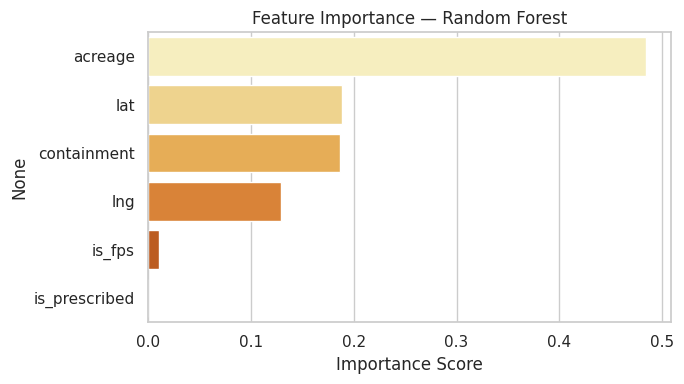

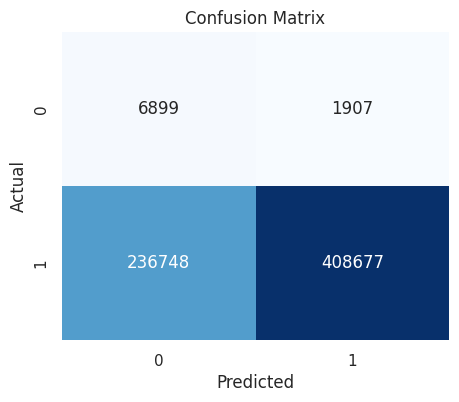

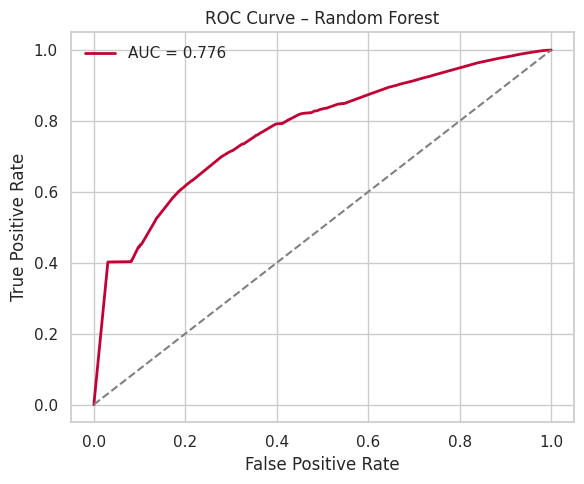

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve)

features = ["containment", "acreage", "is_fps", "is_prescribed", "lat", "lng"]
merged["delayed"] = (merged["lag_min"] > 60).astype(int)

for f in features:
    merged[f] = pd.to_numeric(merged[f], errors="coerce")

model_data = merged.dropna(subset=features + ["delayed"]).copy()
X = model_data[features]
y = model_data["delayed"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

# SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# BASELINE: RandomForest

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

print("\n=== Random Forest Performance ===")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))

# FEATURE IMPORTANCE

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=importances.values, y=importances.index, palette="YlOrBr")
plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC CURVE

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="#c20235", lw=2, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


= Gradient Boosting Performance =
              precision    recall  f1-score   support

           0      0.600     0.001     0.001      8806
           1      0.987     1.000     0.993    645425

    accuracy                          0.987    654231
   macro avg      0.793     0.500     0.497    654231
weighted avg      0.981     0.987     0.980    654231

ROC-AUC: 0.8373


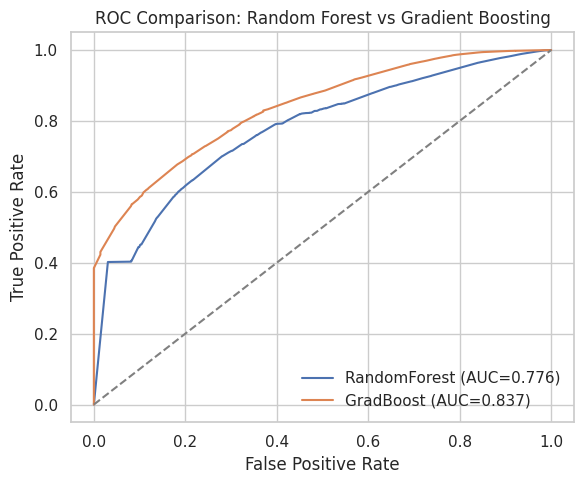

In [31]:
# Gradient Boosting

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_test_scaled)
y_prob_gb = gb.predict_proba(X_test_scaled)[:,1]

print("\n= Gradient Boosting Performance =")
print(classification_report(y_test, y_pred_gb, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_gb), 4))

# MODEL COMPARISON

plt.figure(figsize=(6,5))
plt.plot(*roc_curve(y_test, y_prob)[:2], label=f"RandomForest (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot(*roc_curve(y_test, y_prob_gb)[:2], label=f"GradBoost (AUC={roc_auc_score(y_test, y_prob_gb):.3f})")
plt.plot([0,1],[0,1],'--',color="gray")
plt.title("ROC Comparison: Random Forest vs Gradient Boosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import shap
shap.initjs()

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_scaled)
if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[1]

print("\nTop SHAP features for Random Forest:")
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", color="#E26A4A")
shap.summary_plot(shap_values_rf, X_test, color="#E26A4A")
shap.dependence_plot("acreage", shap_values_rf, X_test, display_features=X_test)

explainer_gb = shap.Explainer(gb)
shap_values_gb = explainer_gb(X_test_scaled)

print("\nTop SHAP features for Gradient Boosting:")
shap.summary_plot(shap_values_gb, X_test, plot_type="bar", color="#c20235")
shap.summary_plot(shap_values_gb, X_test, color="#c20235")
shap.dependence_plot("containment", shap_values_gb.values, X_test, display_features=X_test)

## Results

Report your final results and key insights:
- Metrics: Precision, Recall, ROC AUC, RMSE, etc.
- Key findings or visualizations (include in slides)
- Any limitations or ethical considerations

## Team Contributions

| Name         | Contributions                                |
|--------------|----------------------------------------------|
| Gianina Petrașcu       | Feature engineering, model tuning            |
| Ioana Bîrlan           | EDA, preprocessing, geospatial joins         |